In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from models import*
from load_data import loaddata,loaddata_with_label_map
from train_utils import TrainModel,validation,show_result

In [35]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.5):
        super(LSTMNet, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True)
        self.lstm3 = nn.LSTM(128, 64, batch_first=True)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm1(x)
        
        x, _ = self.lstm2(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)
        
        x = x[:, -1, :]
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def freeze(self, layer_name):
        # 冻结指定层
        for param in getattr(self, layer_name).parameters():
            param.requires_grad = False

    def unfreeze(self, layer_name):
        # 解冻指定层
        for param in getattr(self, layer_name).parameters():
            param.requires_grad = True

get data from folder

In [36]:
# DATA_PATH = '../WLASL_agument (final)'
DATA_PATH = '/home/lizi/Desktop/WLASL_agument(combine)'


X,Y ,map= loaddata(DATA_PATH)
print(map)     

(3940, 30, 1662)
(3940,)
{'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}


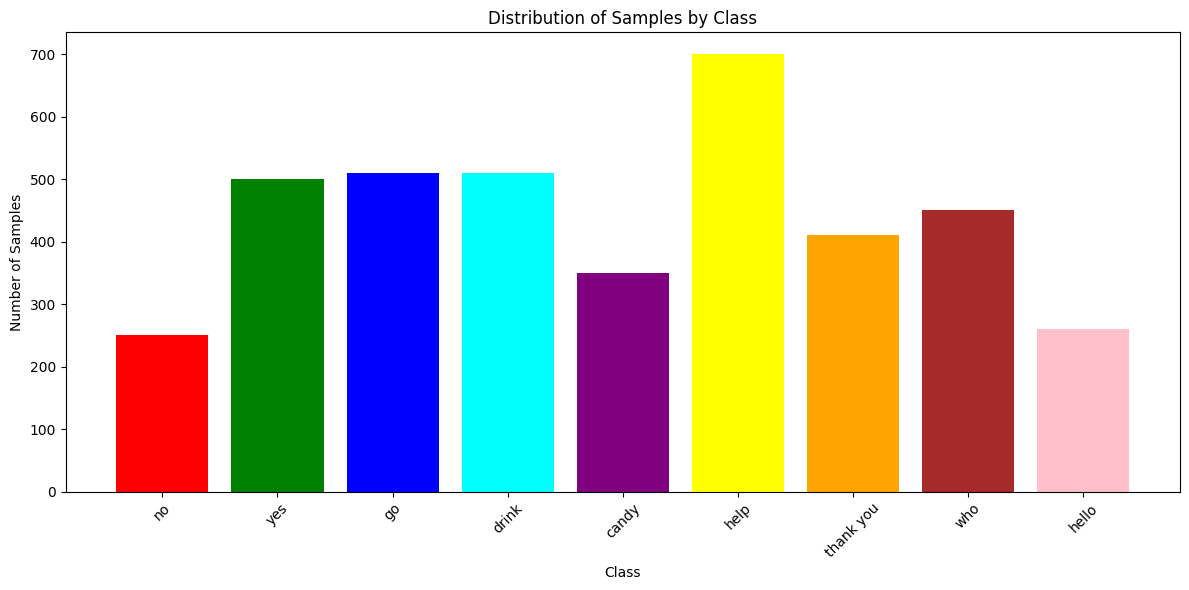

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(Y, label_map):
    # 统计每个类别的样本数量
    unique, counts = np.unique(Y, return_counts=True)
    
    # 准备数据
    # labels = [label_map[key] for key in unique]
    # 从整数标签转换回原始标签名称
    labels = [key for key, value in label_map.items() if value in unique]

    values = counts

    # 绘制柱形图
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color=['red', 'green', 'blue', 'cyan', 'purple', 'yellow', 'orange', 'brown', 'pink'])
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Samples by Class')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

# 调用函数
label_map = {'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}
plot_class_distribution(Y, label_map)


split and load data

In [6]:
#train_test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#set batch size while create dataloader
#train dataloader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
#val dataloader
val_data = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(Y_test, dtype=torch.long))
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)

<h3>LSTM model

model instantiation & select device 

In [38]:
input_size = 1662
num_classes = len(map)
model_lstm = LSTMNet(input_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train the model

In [39]:
criterion = nn.CrossEntropyLoss()
#set learning rate
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.0001)
num_epochs = 60


train_lstm = TrainModel(model_lstm,device,criterion,optimizer)
trained_model_lstm, train_losses, train_accs, val_losses, val_accs = train_lstm.fit(num_epochs,train_loader,val_loader)

Start training!
Epoch: 10/60:Train loss: 1.512,Train acc: 0.350,Val loss: 1.518,Val acc.: 0.345
Epoch: 20/60:Train loss: 1.405,Train acc: 0.415,Val loss: 1.349,Val acc.: 0.449
Epoch: 30/60:Train loss: 1.022,Train acc: 0.576,Val loss: 0.869,Val acc.: 0.662
Epoch: 40/60:Train loss: 0.576,Train acc: 0.768,Val loss: 0.540,Val acc.: 0.797
Epoch: 50/60:Train loss: 0.458,Train acc: 0.820,Val loss: 0.382,Val acc.: 0.855
Epoch: 60/60:Train loss: 0.610,Train acc: 0.787,Val loss: 0.313,Val acc.: 0.876


In [40]:
print(len(train_losses))
print(len(val_losses))

60
60


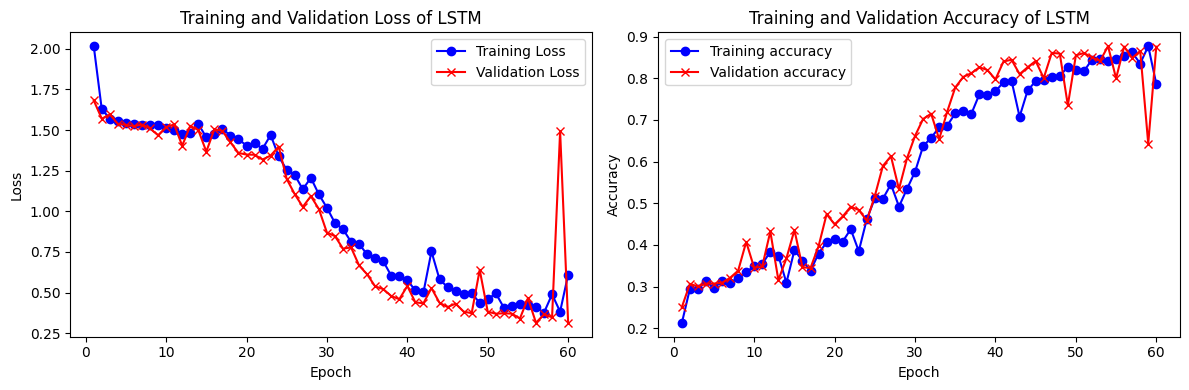

In [41]:
show_result(train_losses,train_accs,val_losses,val_accs)

In [42]:
torch.save({'model_state_dict': trained_model_lstm.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs,
            }, "./lstm_model.ckpt")

In [12]:
lstm_wlasl_model =LSTMNet(input_size, num_classes)# fill-in the arguments if needed
checkpoint = torch.load("lstm_model.ckpt")
lstm_wlasl_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [43]:
# DATA_PATH = '../WLASL_agument (final)'
DATA_PATH = '/home/lizi/Desktop/lizi'

X_my,Y_my = loaddata_with_label_map(DATA_PATH,label_map)

(120, 30, 1662)
(120,)


In [44]:
_, X_mytest, _, Y_mytest = train_test_split(X_my, Y_my, random_state=21,test_size=1)

#test dataloader
test_data = TensorDataset(torch.tensor(X_my, dtype=torch.float), torch.tensor(Y_my, dtype=torch.long))
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

Test on test guest

In [45]:
from train_utils import validation


lstm_wlasl_model =LSTMNet(input_size, num_classes)# fill-in the arguments if needed
checkpoint = torch.load("lstm_model.ckpt")
lstm_wlasl_model.load_state_dict(checkpoint['model_state_dict'])

a = validation(lstm_wlasl_model,val_loader)

print(a)

0.8753164486040043


FINE TUNING

freeze the model

In [49]:
lstm_wlasl_model.freeze('lstm1')
lstm_wlasl_model.freeze('lstm2')

lstm_wlasl_model.freeze('lstm3')




In [50]:

X_my,Y_my = loaddata_with_label_map(DATA_PATH,label_map)
X_mytrain, X_myval, Y_mytrain, Y_myval = train_test_split(X_my, Y_my, random_state=21,test_size=0.2)
#test dataloader
mytrain = TensorDataset(torch.tensor(X_mytrain, dtype=torch.float), torch.tensor(Y_mytrain, dtype=torch.long))
mytrain_loader = DataLoader(mytrain, batch_size=10, shuffle=True)
#test dataloader
myval = TensorDataset(torch.tensor(X_myval, dtype=torch.float), torch.tensor(Y_myval, dtype=torch.long))
myval_loader = DataLoader(myval, batch_size=10, shuffle=True)

optimizer1 = torch.optim.Adam(model_lstm.parameters(), lr=0.000001)

num_epochs = 60

fine_tuning = TrainModel(lstm_wlasl_model,device,criterion,optimizer1)
tuned_lstm, train_losses_tune, train_accs_tune, val_losses_tune, val_accs_tune = fine_tuning.fit(num_epochs,mytrain_loader,myval_loader)

(120, 30, 1662)
(120,)
Start training!
Epoch: 10/60:Train loss: 0.286,Train acc: 0.973,Val loss: 0.267,Val acc.: 0.967
Epoch: 20/60:Train loss: 0.259,Train acc: 0.960,Val loss: 0.660,Val acc.: 0.917
Epoch: 30/60:Train loss: 0.230,Train acc: 0.980,Val loss: 0.267,Val acc.: 0.967
Epoch: 40/60:Train loss: 0.184,Train acc: 0.980,Val loss: 0.267,Val acc.: 0.967
Epoch: 50/60:Train loss: 0.192,Train acc: 0.980,Val loss: 0.268,Val acc.: 0.967
Epoch: 60/60:Train loss: 0.228,Train acc: 0.980,Val loss: 0.267,Val acc.: 0.967


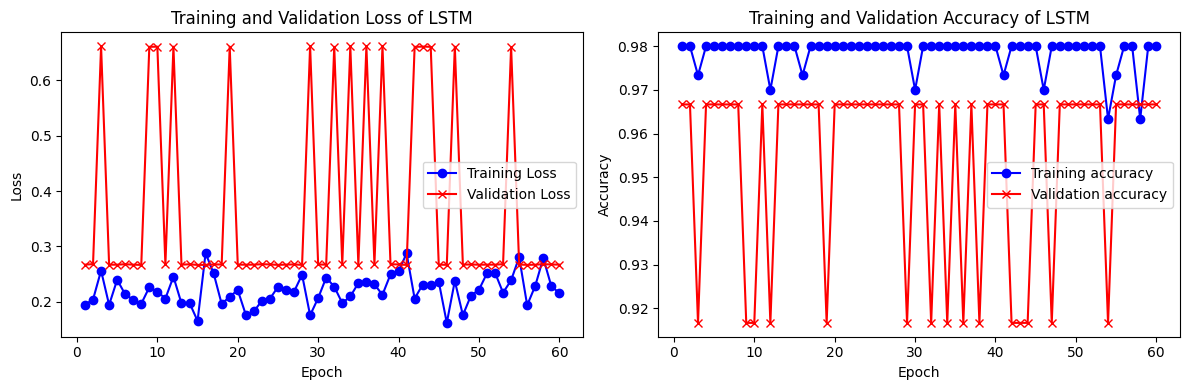

In [48]:
show_result(train_losses_tune, train_accs_tune, val_losses_tune, val_accs_tune)

In [51]:
torch.save({'model_state_dict': tuned_lstm.state_dict(),
            'train_losses': train_losses_tune,
            'train_accs': train_accs_tune,
            'val_losses': val_losses_tune,
            'val_accs': val_accs_tune,
            }, "./fine_tuned_lstm_model.ckpt")

Transformer+lstm

In [74]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
class TransformerLSTMClassifier1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TransformerLSTMClassifier1, self).__init__()
        
        self.embedding_size = input_dim
        self.positional_encoder = PositionalEncoding(self.embedding_size)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embedding_size, nhead=1, dropout=0.9)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # LSTM Layer
        self.lstm = nn.LSTM(self.embedding_size, 32, batch_first=True)  # 输出维度为64
        
        self.decoder = nn.Linear(32, num_classes)
          # 因为LSTM的输出维度是64
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Positional Encoding and Transformer Encoding
        x = self.positional_encoder(x)
        x = self.transformer_encoder(x)
        
        # LSTM Layer
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        
        x = self.decoder(x)
        return x
    def freeze(self, layer_name):
        # 冻结指定层
        for param in getattr(self, layer_name).parameters():
            param.requires_grad = False

    def unfreeze(self, layer_name):
        # 解冻指定层
        for param in getattr(self, layer_name).parameters():
            param.requires_grad = True

In [63]:
# DATA_PATH = '../WLASL_agument (final)'
DATA_PATH = '/home/lizi/Desktop/WLASL_agument(combine)'


X,Y ,map= loaddata(DATA_PATH)
print(map)     

(3940, 30, 1662)
(3940,)
{'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}


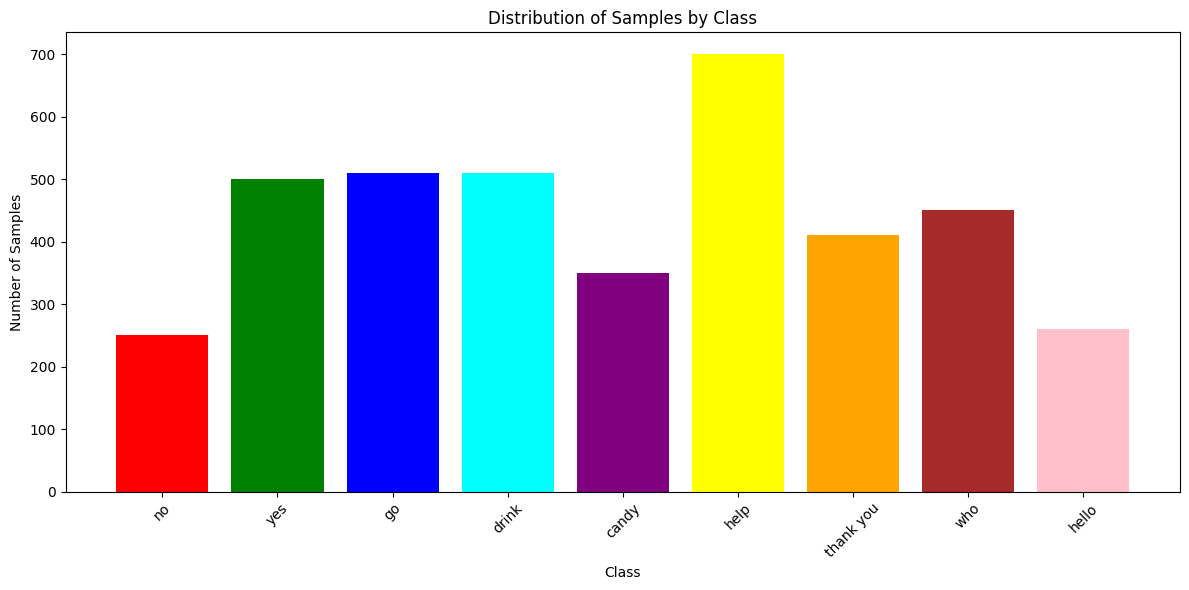

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(Y, label_map):
    # 统计每个类别的样本数量
    unique, counts = np.unique(Y, return_counts=True)
    
    # 准备数据
    # labels = [label_map[key] for key in unique]
    # 从整数标签转换回原始标签名称
    labels = [key for key, value in label_map.items() if value in unique]

    values = counts

    # 绘制柱形图
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color=['red', 'green', 'blue', 'cyan', 'purple', 'yellow', 'orange', 'brown', 'pink'])
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Samples by Class')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

# 调用函数
label_map = {'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}
plot_class_distribution(Y, label_map)

In [75]:
#train_test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#set batch size while create dataloader
#train dataloader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
#val dataloader
val_data = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(Y_test, dtype=torch.long))
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)

In [76]:
input_size = 1662
num_classes = len(map)
model_tranlstm = TransformerLSTMClassifier1(input_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
criterion = nn.CrossEntropyLoss()
#set learning rate
optimizer = torch.optim.Adam(model_tranlstm.parameters(), lr=0.0001)
num_epochs = 60


train_tranlstm = TrainModel(model_tranlstm,device,criterion,optimizer)
trained_model_tranlstm, train_losses, train_accs, val_losses, val_accs = train_tranlstm.fit(num_epochs,train_loader,val_loader)

Start training!
Epoch: 10/60:Train loss: 2.179,Train acc: 0.163,Val loss: 2.157,Val acc.: 0.180
Epoch: 20/60:Train loss: 2.163,Train acc: 0.177,Val loss: 2.144,Val acc.: 0.180
Epoch: 30/60:Train loss: 2.163,Train acc: 0.177,Val loss: 2.141,Val acc.: 0.180
Epoch: 40/60:Train loss: 2.154,Train acc: 0.177,Val loss: 2.146,Val acc.: 0.180
Epoch: 50/60:Train loss: 1.893,Train acc: 0.267,Val loss: 2.147,Val acc.: 0.181
Epoch: 60/60:Train loss: 1.628,Train acc: 0.299,Val loss: 2.177,Val acc.: 0.134


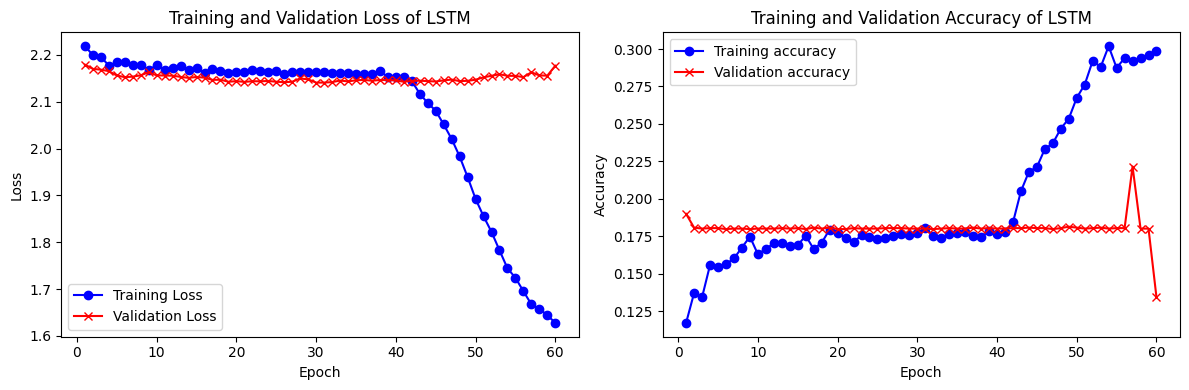

In [78]:
show_result(train_losses,train_accs,val_losses,val_accs)